# Report Without Ground Truth v1.0
## Input prameters

In [20]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser

pd.options.display.float_format = lambda x: '{:,.1e}'.format(x) if x>1e6 else '{:,.1f}'.format(x)
pd.options.display.max_colwidth = 100

configFile='no_gt_report.config'
parser = ConfigParser()
parser.read(configFile)

no_gt_statistics_unfiltered_files = parser.get('NOGTReport', 'h5_statistics', fallback='no_gt_statistics_unfiltered.h5').split(',')
no_gt_statistics_filtered_files = parser.get('NOGTReport', 'filtered_h5_statistics', fallback='no_gt_statistics_filtered.h5').split(',')
no_gt_statistics_unfiltered_file_wgs = parser.get('NOGTReport', 'h5_statistics_wgs', fallback='no_gt_statistics_unfiltered_wgs.h5').split(',')
no_gt_statistics_filtered_file_wgs = parser.get('NOGTReport', 'filtered_h5_statistics_wgs', fallback='no_gt_statistics_filtered_wgs.h5').split(',')

is_somatic = parser.getboolean('NOGTReport', 'is_somatic', fallback=False)
filtered_vcf = parser.get('NOGTReport', 'filtered_vcf',fallback='filtered_vcf.vcf.gz')
annotation_intervals_names=parser.get('NOGTReport', 'annotation_intervals_names',fallback='annotation_intervals_names').split(',')
interval_list = parser.get('NOGTReport', 'interval_list')
ref_fasta = parser.get('NOGTReport', 'ref_fasta',fallback='Homo_sapiens_assembly38.fasta')
ref_fasta_dict = parser.get('NOGTReport', 'ref_fasta_dict', fallback='Homo_sapiens_assembly38.dict')

prmNames=['run_id','pipeline_version',
          'h5_statistics', 'filtered_h5_statistics'
          'h5_statistics_wgs', 'filtered_h5_statistics_wgs','annotation_intervals_names','is_somatic','filtered_vcf',
          'interval_list'
         ]

prm={}
for name in prmNames:
    prm[name]=parser.get('NOGTReport', name)
    
h5outfile = parser.get('NOGTReport', 'h5_output', fallback='no_gt_report.h5')

prmdf = pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)
prmdf.to_hdf(h5outfile, key="parameters")
prmdf

,value
run_id,test_staging
pipeline_version,1.1.5
h5_statistics,"no_gt_statistics_unfiltered_wgs.h5,no_gt_statistics_unfiltered_LCR.h5,no_gt_statistics_unfiltere..."
filtered_h5_statistics,"no_gt_statistics_filtered_wgs.h5,no_gt_statistics_filtered_LCR.h5,no_gt_statistics_filtered_exom..."
annotation_intervals_names,"wgs,LCR,exome,mappability,hmers_7_and_higher"
is_somatic,true
filtered_vcf,test_staging.annotated.AF.vcf.gz
interval_list,/data/wgs_calling_regions.hg38.interval_list


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from os.path import join as pjoin
from matplotlib.lines import Line2D

home=os.environ['HOME']
sys.path.append('/VariantCalling/src/')
from python.utils import revcomp
import python.vcftools as vcftools
import python.pipelines.vcf_pipeline_utils as vcf_pipeline_utils

In [22]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 26
TITLE_SIZE = 36
FIGSIZE = (16, 8)
GRID = True
COLORS = [
    "blue",
    "red",
    "green",
    "magenta",
    "black",
    "brown",
    "orange",
    "salmon",
    "teal",
    "coral",
    "lime",
    "purple",
    "cyan",
    "lavender",
    "turquoise",
    "darkgreen",
    "tan",
    "lightblue",
    "pink",
    "yellow",
    "gold",
]

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=TITLE_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("axes", grid=GRID)  # is grid on
plt.rc("axes", prop_cycle=plt.cycler(color=COLORS))
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=TITLE_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=FIGSIZE)  # size of the figure

# Variants Statistics

In [23]:
import pandas as pd
def metric_table_annotation(no_gt_statistics_unfiltered,no_gt_statistics_filtered, annotation_name='none'):   
    #eval
    CompOverlap = pd.read_hdf(no_gt_statistics_unfiltered,'eval_CompOverlap')
    CountVariants = pd.read_hdf(no_gt_statistics_unfiltered,'eval_CountVariants')
    TiTvVariantEvaluator = pd.read_hdf(no_gt_statistics_unfiltered,'eval_TiTvVariantEvaluator')
    IndelSummary = pd.read_hdf(no_gt_statistics_unfiltered,'eval_IndelSummary')

    filtered_CompOverlap = pd.read_hdf(no_gt_statistics_filtered,'eval_CompOverlap')
    filtered_CountVariants = pd.read_hdf(no_gt_statistics_filtered,'eval_CountVariants')
    filtered_TiTvVariantEvaluator = pd.read_hdf(no_gt_statistics_filtered,'eval_TiTvVariantEvaluator')
    filtered_IndelSummary = pd.read_hdf(no_gt_statistics_filtered,'eval_IndelSummary')
    CompOverlap = CompOverlap.drop(["CompOverlap","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
    CompOverlap.columns = pd.Series(CompOverlap.iloc[0])
    CompOverlap = CompOverlap[1::].loc[["nEvalVariants"]]

    filtered_CompOverlap = filtered_CompOverlap.drop(["CompOverlap","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
    filtered_CompOverlap.columns = pd.Series(filtered_CompOverlap.iloc[0])
    filtered_CompOverlap = filtered_CompOverlap[1::].loc[["nEvalVariants"]]

    CountVariants = CountVariants.drop(["CountVariants","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
    CountVariants.columns = pd.Series(CountVariants.iloc[0])
    CountVariants = CountVariants[1::].loc[["nDeletions","nInsertions","nSNPs"]]

    filtered_CountVariants = filtered_CountVariants.drop(["CountVariants","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
    filtered_CountVariants.columns = pd.Series(filtered_CountVariants.iloc[0])
    filtered_CountVariants = filtered_CountVariants[1::].loc[["nDeletions","nInsertions","nSNPs"]]

    TiTvVariantEvaluator = TiTvVariantEvaluator.drop(["TiTvVariantEvaluator","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
    TiTvVariantEvaluator.columns = pd.Series(TiTvVariantEvaluator.iloc[0])
    TiTvVariantEvaluator = TiTvVariantEvaluator[1::].loc[["nTi","nTv","tiTvRatio"]]

    filtered_TiTvVariantEvaluator = filtered_TiTvVariantEvaluator.drop(["TiTvVariantEvaluator","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
    filtered_TiTvVariantEvaluator.columns = pd.Series(filtered_TiTvVariantEvaluator.iloc[0])
    filtered_TiTvVariantEvaluator = filtered_TiTvVariantEvaluator[1::].loc[["nTi","nTv","tiTvRatio"]]

    IndelSummary = IndelSummary.drop(["IndelSummary","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
    IndelSummary.columns = pd.Series(IndelSummary.iloc[0])
    IndelSummary = IndelSummary[1::].loc[[
                           "SNP_het_to_hom_ratio",
                           "SNP_to_indel_ratio",
                           "indel_het_to_hom_ratio",
                           "indel_novelty_rate",
                           "insertion_to_deletion_ratio"]]

    filtered_IndelSummary = filtered_IndelSummary.drop(["IndelSummary","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
    filtered_IndelSummary.columns = pd.Series(filtered_IndelSummary.iloc[0])
    filtered_IndelSummary = filtered_IndelSummary[1::].loc[[
                           "SNP_het_to_hom_ratio",
                           "SNP_to_indel_ratio",
                           "indel_het_to_hom_ratio",
                           "indel_novelty_rate",
                           "insertion_to_deletion_ratio"]]

    unfiltered = pd.concat([CompOverlap, CountVariants, TiTvVariantEvaluator, IndelSummary], axis=0)
    filtered = pd.concat([filtered_CompOverlap, filtered_CountVariants, filtered_TiTvVariantEvaluator, filtered_IndelSummary], axis=0)


    merged_df = pd.concat([unfiltered, filtered], axis=1, keys=["unfiltered","filtered"])

    if is_somatic:
        merged_df = merged_df.drop(["SNP_het_to_hom_ratio","indel_het_to_hom_ratio"], axis=0)
    merged_df.to_hdf(h5outfile, key="variants_statistics")
    
    mi = pd.MultiIndex.from_tuples([(annotation_name, itm) for itm in list(merged_df.index)],names=['regions','metrics'])
    merged_df.set_index(mi,inplace=True)
    return(merged_df)


In [24]:
def metric_table(no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names):
    frames = []
    for no_gt_statistics_unfiltered,no_gt_statistics_filtered,annotation_name in zip(no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names):
        cur_result = metric_table_annotation(no_gt_statistics_unfiltered,no_gt_statistics_filtered,annotation_name)
        frames.append(cur_result)
    result = pd.concat(frames)
    return result

metric_table(no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names)


unfiltered                  \
Novelty                                               all   known   novel   
regions            metrics                                                  
wgs                nEvalVariants                  1528076  954498  573578   
                   nDeletions                      241998   56794  185204   
                   nInsertions                     254474   48453  206021   
                   nSNPs                          1022274  844987  177287   
                   nTi                             645561  569909   75652   
                   nTv                             375464  274277  101187   
                   tiTvRatio                         1.72    2.08    0.75   
                   SNP_to_indel_ratio                2.01    7.41    0.45   
                   indel_novelty_rate               77.57    0.00  100.00   
                   insertion_to_deletion_ratio       1.05    0.87    1.11   
LCR                nEvalVariants                   160223   66283   93940   
                   nDeletions                       48557   22192   26365   
                   nInsertions                      32525   13466   19059   
                   nSNPs                            73413   27201   46212   
                   nTi                              35878   13581   22297   
                   nTv                              37162   13516   23646   
                   tiTvRatio                         0.97    1.00    0.94   
                   SNP_to_indel_ratio                0.82    0.64    0.99   
                   indel_novelty_rate               52.38    0.00  100.00   
                   insertion_to_deletion_ratio       0.68    0.63    0.73   
exome              nEvalVariants                    12640    5297    7343   
                   nDeletions                        2142      65    2077   
                   nInsertions                       3785      51    3734   
                   nSNPs                             6682    5179    1503   
                   nTi                               4266    3801     465   
                   nTv                               2403    1366    1037   
                   tiTvRatio                         1.78    2.78    0.45   
                   SNP_to_indel_ratio                1.12   43.26    0.26   
                   indel_novelty_rate               97.99    0.00  100.00   
                   insertion_to_deletion_ratio       1.78    0.79    1.81   
mappability        nEvalVariants                  1507055  948691  558364   
                   nDeletions                      239885   56663  183222   
                   nInsertions                     251459   48388  203071   
                   nSNPs                          1006459  839376  167083   
                   nTi                             637672  566291   71381   
                   nTv                             367574  272294   95280   
                   tiTvRatio                         1.73    2.08    0.75   
                   SNP_to_indel_ratio                2.00    7.37    0.43   
                   indel_novelty_rate               77.38    0.00  100.00   
                   insertion_to_deletion_ratio       1.05    0.87    1.11   
hmers_7_and_higher nEvalVariants                    88570   31921   56649   
                   nDeletions                       28035   14377   13658   
                   nInsertions                       8798    2182    6616   
                   nSNPs                            49895   14750   35145   
                   nTi                              22708    5178   17530   
                   nTv                              26895    9525   17370   
                   tiTvRatio                         0.84    0.54    1.01   
                   SNP_to_indel_ratio                1.29    0.83    1.67   
                   indel_novelty_rate               54.30    0.00  100.00   
                   insertion_to_deletion_ra


<ul>
<li><b>nEvalVariants</b>- the number of variants <br></li>
<li><b>nDeletions</b>- the number of variants determined to be deletions <br></li>
<li><b>nDeletions</b>- the number of variants determined to be deletions <br></li>
<li><b>nInsertions</b>- the number of variants determined to be insertions <br></li>
<li><b>nSNPs</b>- the number of variants determined to be single-nucleotide polymorphisms <br></li>
<li><b>nTi</b>- number of transition variants (A↔G or T↔C) <br></li>
<li><b>nTv</b>- number of transversion variants (A↔T or G↔C) <br></li>
<li><b>SNP_to_indel_ratio</b>- n_SNPs divided by n_indels <br></li>
<li><b>indel_novelty_rate</b>- n_novel_indels divided by n_indels<br></li>
<li><b>insertion_to_deletion_ratio</b>- n_insertions divided by n_deletions<br></li>
</ul>





In [25]:
from IPython.display import display, Markdown

if is_somatic:
    display(Markdown("""# Distribution of Allele fractions
    Histogram of 100 bins of Allele fraction for the somatic data. \n
    """))

# Distribution of Allele fractions
    Histogram of 100 bins of Allele fraction for the somatic data. 

    

In [26]:
def af_hist_graph_annot(filtered_af_hist, annotation_name='none'):
    nbins = 100
    bin_edges = pd.Series(np.arange(0,1,1/nbins))

    for group in filtered_af_hist.columns:

        plt.plot(bin_edges,filtered_af_hist[group]/np.sum(filtered_af_hist[group])*100, alpha=0.5, label=group, linewidth = '3')
        plt.legend(loc='upper right')
        plt.xlabel("Estimated allele fraction")
        plt.ylabel("% Variants")
        plt.title(f'{annotation_name} Pass filter AF histogram', fontsize=24)
    plt.show()

In [27]:
def af_hist_graph(no_gt_statistics_filtered_files, annotation_intervals_names):
    for no_gt_statistics_filtered,annotation_name in zip(no_gt_statistics_filtered_files,annotation_intervals_names):
        filtered_af_hist = pd.read_hdf(no_gt_statistics_filtered,'af_hist')
        af_hist_graph_annot(filtered_af_hist,annotation_name)

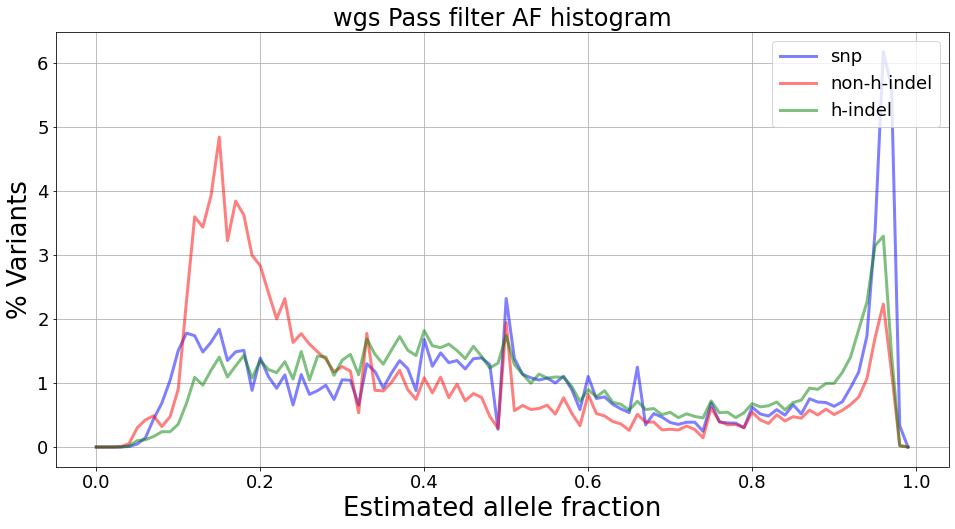

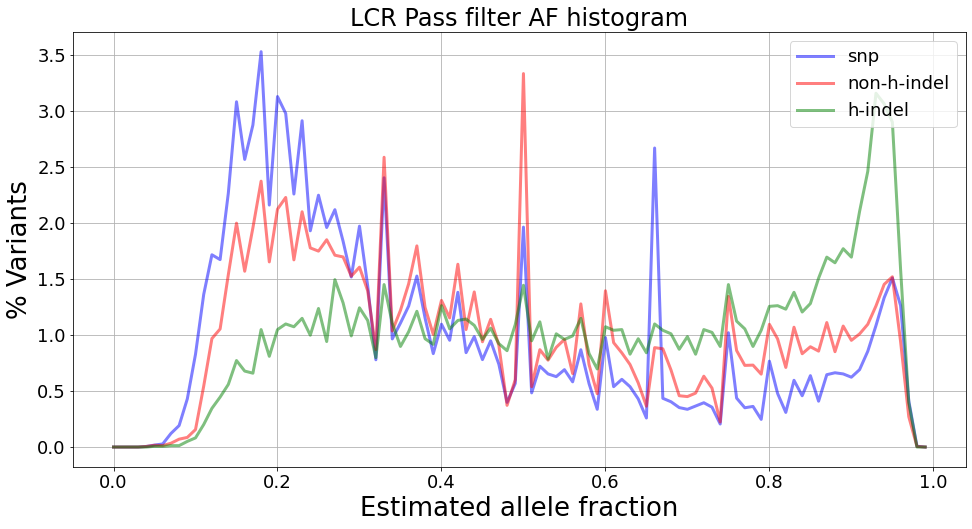

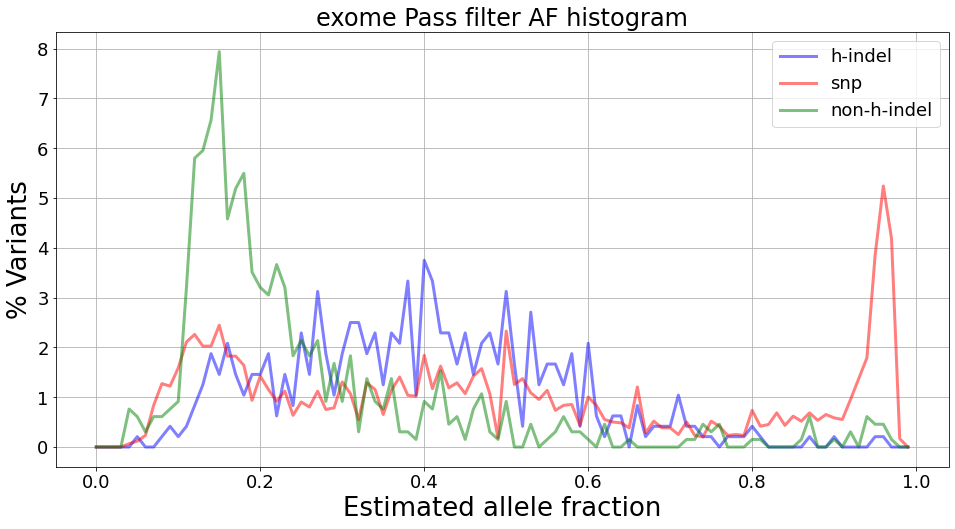

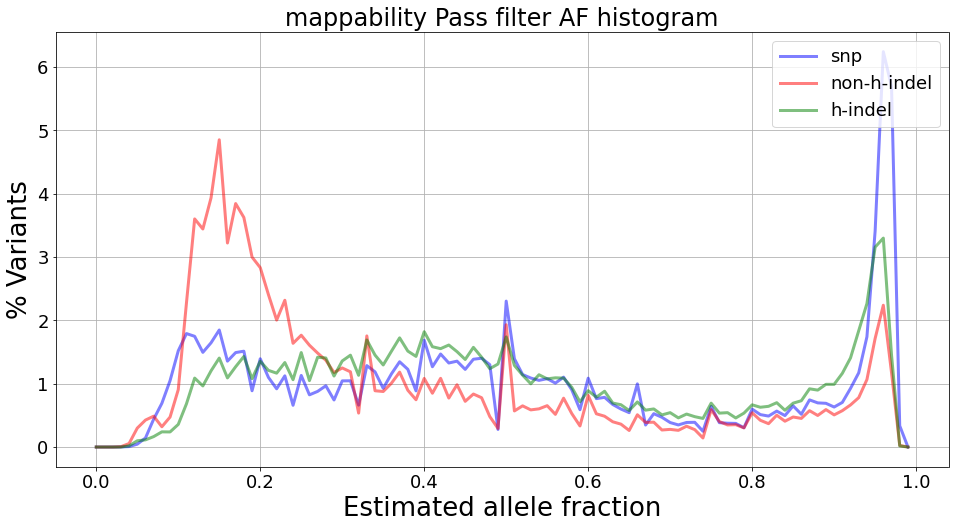

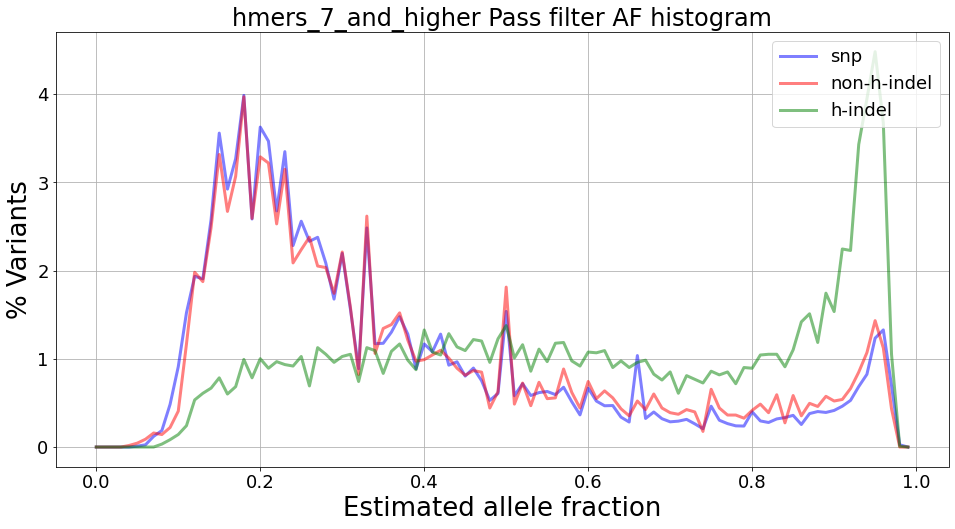

In [28]:
if is_somatic:
    af_hist_graph(no_gt_statistics_filtered_files, annotation_intervals_names)

In [29]:
# FDR Analysis

filtered_vcf_df = vcftools.get_vcf_df(filtered_vcf)
run_fpr = not all(filtered_vcf_df['filter'] == '')

In [30]:
if run_fpr:
    display(Markdown("""# FDR Analysis
    """))

# FDR Analysis
    

In [31]:
if run_fpr:

    novel_vcf_df = filtered_vcf_df[filtered_vcf_df['db']!=True]
    novel_pass_vcf_df = novel_vcf_df[novel_vcf_df['filter']=='PASS']

<!--  ## MetricsCollection -->

In [32]:
def FDR_graph(interval_size,fprs,pass_fps, ax=None,title = None,color='darkorange'):

    params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
    plt.rcParams.update(params)
    if ax is None:
        plt.figure()
        ax = plt.gca()
        ax.set_aspect('equal', 'datalim')
        #ax.set_aspect('equal', 'box')
        plt.axis('scaled')
        ax.grid()
        ax.rcParams.update(params)
    plt.sca(ax)
    
    fprs = pd.Series(fprs).dropna()
    pass_fprs = pd.Series(pass_fps).dropna()
    select_size = len(fprs)
    pass_select_size = len(pass_fprs)
    expected_below = fprs*interval_size
    pass_expected_below = pass_fprs*interval_size
    actual = np.arange(select_size)
    pass_actual = np.arange(pass_select_size)
    plt.xlabel('Expected # FP variants', fontsize=30)
    plt.ylabel('Observed #variants', fontsize=30)
    plt.title(title, fontsize=14)
    plt.rcParams['axes.labelsize'] = 30
    plt.rcParams['axes.titlesize'] = 30

    
    plt.loglog(expected_below, expected_below,color='royalblue')
    plt.loglog(expected_below, actual,'.',color='darkorange')
    plt.loglog(pass_expected_below, pass_actual,'.',color='green')
    plt.legend(labels=['Expected','All', 'Pass'])
    
    
    

In [33]:
# interval_size 10**6
if run_fpr:
    interval_obj = vcf_pipeline_utils.IntervalFile(interval_list, ref_fasta, ref_fasta_dict)
    interval_size = vcf_pipeline_utils.bed_file_length(interval_obj.as_bed_file())


FileNotFoundError: [Errno 2] No such file or directory: 'picard': 'picard'

NameError: name 'interval_size' is not defined

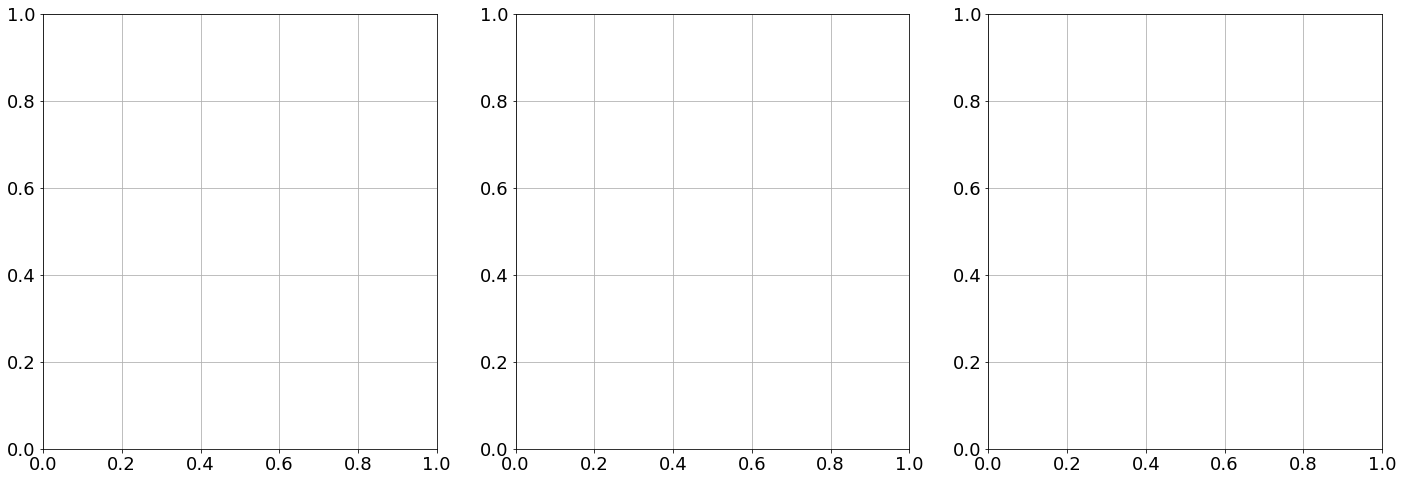

In [34]:
if run_fpr:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
    fprs= np.sort(novel_vcf_df[(novel_vcf_df['variant_type']=='snp')]['fpr']/(10**6))
    pass_fps = np.sort(novel_pass_vcf_df[(novel_pass_vcf_df['variant_type']=='snp')]['fpr']/(10**6))
    FDR_graph(interval_size,fprs,pass_fps,axes[0],'FDR novel snp')

    fprs= np.sort(novel_vcf_df[(novel_vcf_df['variant_type']=='non-h-indel')]['fpr']/(10**6))
    pass_fps = np.sort(novel_pass_vcf_df[(novel_pass_vcf_df['variant_type']=='non-h-indel')]['fpr']/(10**6))
    FDR_graph(interval_size,fprs,pass_fps,axes[1],'FDR novel non-h-indel')

    fprs= np.sort(novel_vcf_df[(novel_vcf_df['variant_type']=='h-indel')]['fpr']/(10**6))
    pass_fps = np.sort(novel_pass_vcf_df[(novel_pass_vcf_df['variant_type']=='h-indel')]['fpr']/(10**6))
    FDR_graph(interval_size,fprs,pass_fps,axes[2],'FDR novel h-indel')

    fig.tight_layout()
    plt.show()

# Snp statistics
Histogram for motif alterations

In [35]:

base_colors = {"A": "b", "C": "r", "T": "y", "G": "g"}
dpi = 150

def plot_motifs0_bars(motifs_0,ax=None, title_prefix = ""):
    if ax is None:
        plt.figure(figsize=(3, 6))
        ax = plt.gca()
    plt.sca(ax)

    x = (motifs_0).sort_index(ascending=False)
    
    bbox_extra_artists = [
        plt.title(f"{title_prefix} {x.sum():.1E} SNPs".replace("E+0", "E"), fontsize=17)
    ]
    (x / motifs_0.sum() * 100).plot.barh(
        color=[base_colors.get(v) for v in x.index.get_level_values("ref")],
        ax=ax,
    )
    plt.yticks(
        ticks=range(6),
        labels=[
            f"{ref}->{alt}" for ref, alt in x.index.values
        ],
    )
    for j, (_, row) in enumerate(x.to_frame().iterrows()):
        bbox_extra_artists += [
            plt.text(
                row["size"] / motifs_0.sum() * 101,
                j + 0.03,
                f"{row['size']:.1E}".replace("E+0", "E"),
            )
        ]
    plt.ylabel("")
    plt.xlabel("Frequency [%]", fontsize=18)
    # plt.xlim(0, ax.get_xlim()[1]+0.1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    return bbox_extra_artists



In [36]:
import pandas as pd
def snps_statistics_annot(no_gt_statistics_unfiltered,no_gt_statistics_filtered, annotation_name='none'):   
    motifs = pd.read_hdf(no_gt_statistics_unfiltered,'snp_motifs')
    filtered_motifs = pd.read_hdf(no_gt_statistics_filtered,'snp_motifs')    
    
    motifs_0 = motifs.reset_index()
    motifs_0 = (
        motifs_0.assign(ref=motifs_0["ref_motif"].str.slice(1, 2))
        .groupby(["ref", "alt_1"])
        .agg({"size": "sum"})
    )["size"]


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))


    plot_motifs0_bars(motifs_0, axes[0],title_prefix=annotation_name)

    motifs_0 = filtered_motifs.reset_index()
    motifs_0 = (
        motifs_0.assign(ref=motifs_0["ref_motif"].str.slice(1, 2))
        .groupby(["ref", "alt_1"])
        .agg({"size": "sum"})
    )["size"]
    plot_motifs0_bars(motifs_0, axes[1], title_prefix=f"{annotation_name}, Filter Pass")

    fig.tight_layout()

In [37]:
def snps_statistics(the_func,no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names):
    
    for no_gt_statistics_unfiltered,no_gt_statistics_filtered,annotation_name in zip(no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names):
        snps_statistics_annot(no_gt_statistics_unfiltered,no_gt_statistics_filtered,annotation_name)


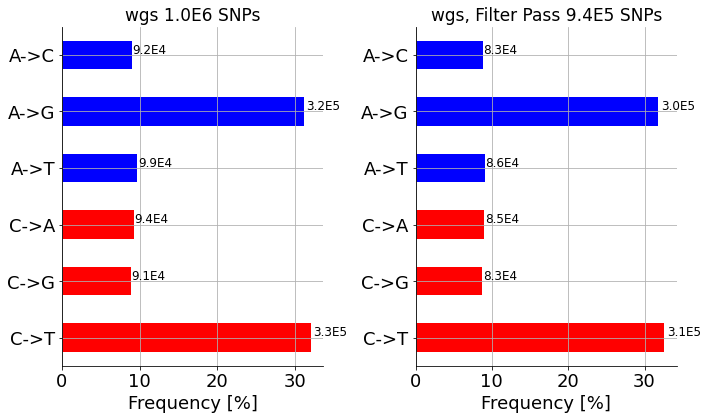

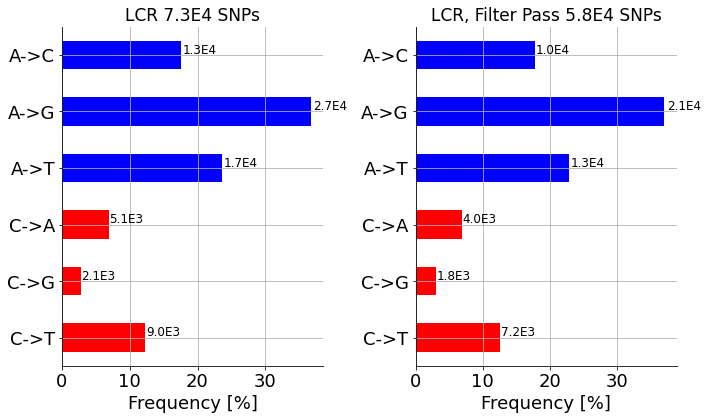

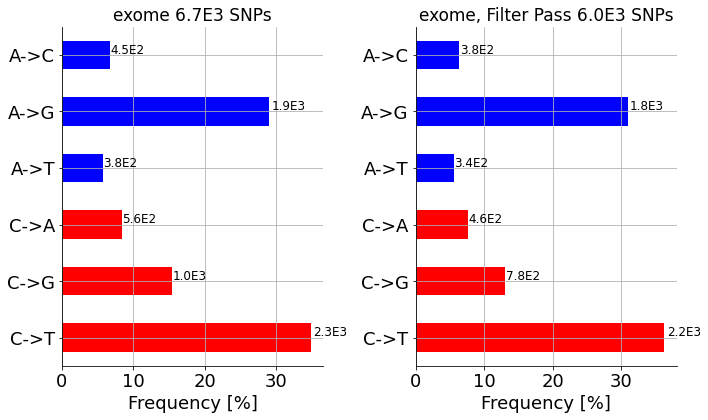

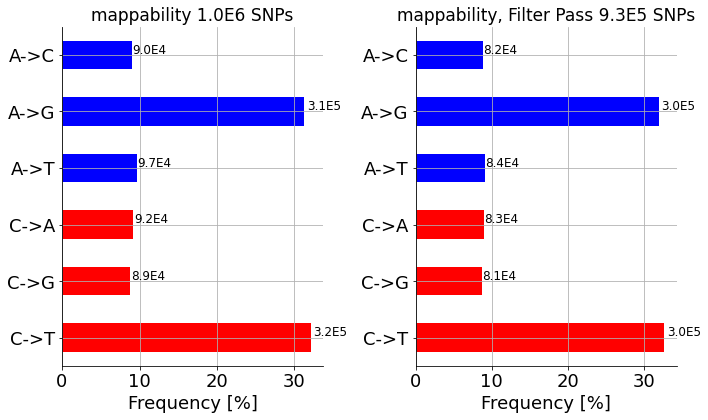

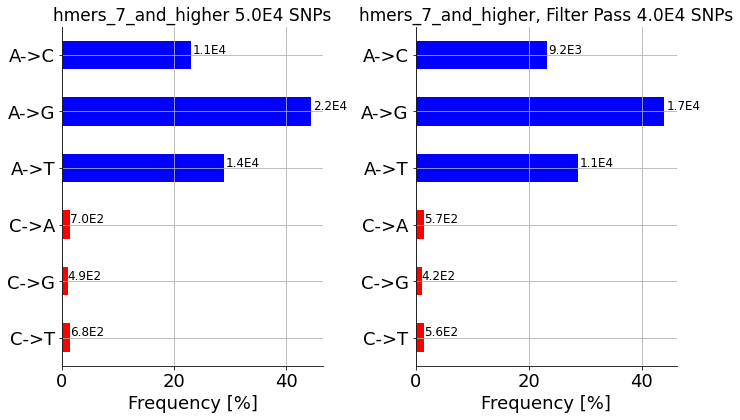

In [38]:

snps_statistics(snps_statistics_annot,no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names)


## Trinucleotide Heatmap
Heatmap for motif alterations in trinucleotide context

In [39]:
def plot_heatmap(motifs,ax=None, title_prefix = ""):
    
    if ax is None:
        plt.figure()
        ax = plt.gca()
    plt.sca(ax)

    plt.title(f"{title_prefix} Trinucleotide context", fontsize=20)
    
    x = (motifs / motifs.sum()).reset_index()
    x = x.assign(
        ref=x["ref_motif"].str.slice(1, 2),
        alt_motif=x["ref_motif"].str.slice(0, 1)
        + x["alt_1"]
        + x["ref_motif"].str.slice(2),
        left=x["ref_motif"].str.slice(0, 1),
        right=x["ref_motif"].str.slice(2),
    )
    x = x.assign(
        family=x.apply(
            lambda y: f"{y['ref']}->{y['alt_1']}",
            axis=1,
        )
    )
    
    table_str = "\n".join(
        (
            x["ref_motif"]
            + "->"
            + x["alt_motif"]
            + "  "
            + (x["size"]).apply(lambda x: f"{x:.1%}")
        )
        .loc[x.sort_values("size", ascending=False).head(12).index]
        .values
    )
    x = x.pivot_table(
        index=[
            "family",
            "left",
        ],
        columns=["right"],
        values="size",
    ).sort_index(ascending=False)
    
    ax.text(
        0.25,
        -0.15,
        table_str,
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="#EEEEEE"),
    )

    bbox_extra_artists = list()
    data = np.concatenate((x.iloc[:12, :], x.iloc[12:, :]), axis=1) * 100
    plt.imshow(data, cmap="viridis")
    cbar = plt.colorbar()
    cbar.ax.get_yaxis().set_ticks(
        range(
            int(np.ceil(min(cbar.ax.get_yaxis().get_ticklocs()))),
            1 + int(max(cbar.ax.get_yaxis().get_ticklocs())),
            10 if (int(max(cbar.ax.get_yaxis().get_ticklocs()))-int(np.ceil(min(cbar.ax.get_yaxis().get_ticklocs())))>10) else 1))
    cbar.ax.set_ylabel("Frequency [%]", fontsize=24, rotation=270, labelpad=30)
    plt.xticks(range(8), list(x.columns) + list(x.columns))
    plt.yticks(range(12), x.iloc[:12, :].index.get_level_values("left"))
    plt.ylabel("Left base")
    plt.xlabel("Right base")
    plt.grid()
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    plt.plot(np.ones(2) * (xlim[0] + (xlim[1] - xlim[0]) / 2), ylim, "-w", linewidth=2)
    plt.plot(xlim, np.ones(2) * (ylim[0] + (ylim[1] - ylim[0]) / 3), "-w", linewidth=2)
    plt.plot(
        xlim, np.ones(2) * (ylim[0] + (ylim[1] - ylim[0]) * 2 / 3), "-w", linewidth=2
    )

    X = np.repeat(
        [
            [
                (xlim[0] + (xlim[1] - xlim[0]) / 4),
                (xlim[0] + (xlim[1] - xlim[0]) * 3 / 4),
            ]
        ],
        3,
        axis=0,
    )
    Y = np.repeat(
        [
            [
                (ylim[0] + (ylim[1] - ylim[0]) * 5 / 6),
                (ylim[0] + (ylim[1] - ylim[0]) * 3 / 6),
                (ylim[0] + (ylim[1] - ylim[0]) / 6),
            ]
        ],
        2,
        axis=0,
    ).T
    T = np.vstack(
        (
            x.iloc[:12:4, :].index.get_level_values("family").values,
            x.iloc[12::4, :].index.get_level_values("family").values,
        )
    ).T

    for xx, yy, tt in zip(X.flatten(), Y.flatten(), T.flatten()):
        plt.text(xx, yy, tt, color="#BB5555", fontsize=28, ha="center", va="center")


In [40]:
def heatmap_annot(no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names):
    
    for no_gt_statistics_unfiltered,no_gt_statistics_filtered,annotation_name in zip(no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names):   
        motifs = pd.read_hdf(no_gt_statistics_unfiltered,'snp_motifs')
        filtered_motifs = pd.read_hdf(no_gt_statistics_filtered,'snp_motifs')   

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 10))

        plot_heatmap(motifs, axes[0], annotation_name)
        plot_heatmap(filtered_motifs, axes[1], f"{annotation_name} Filter Pass")

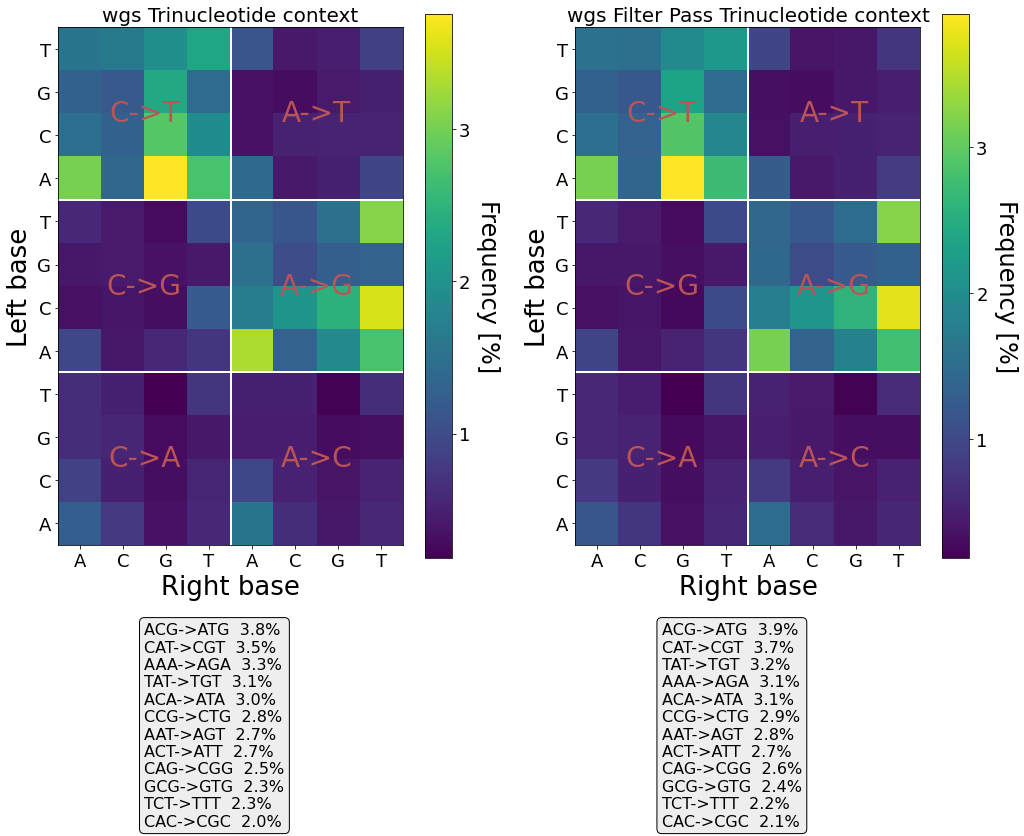

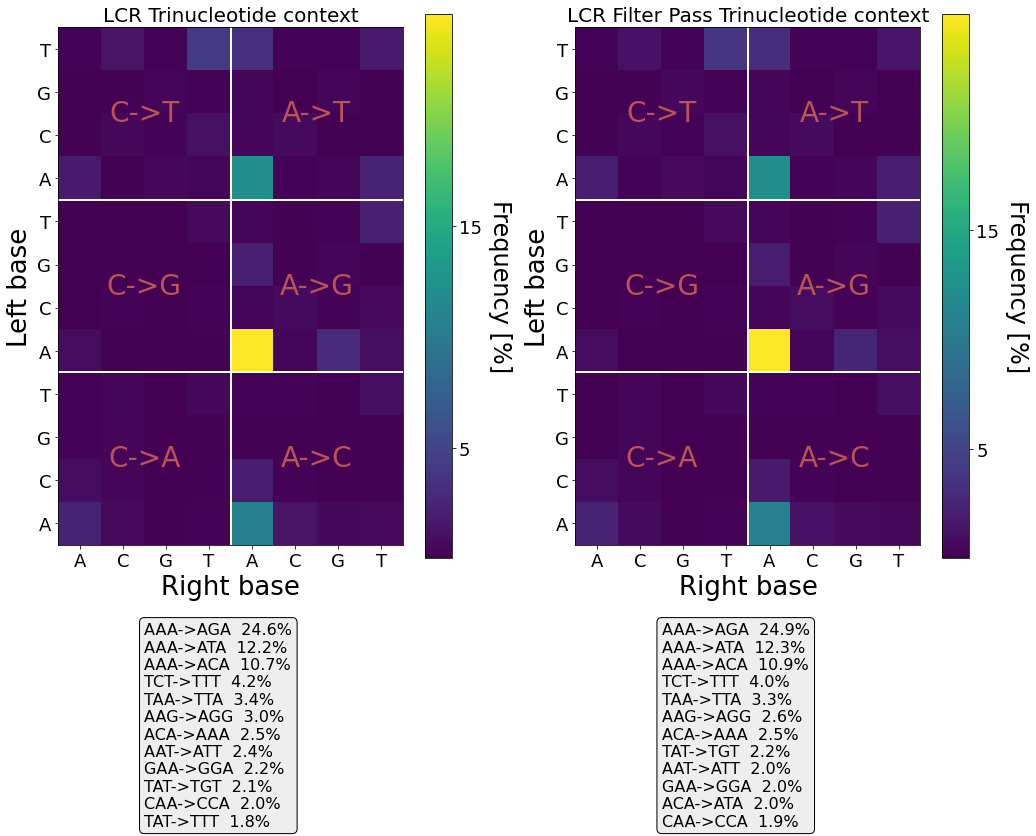

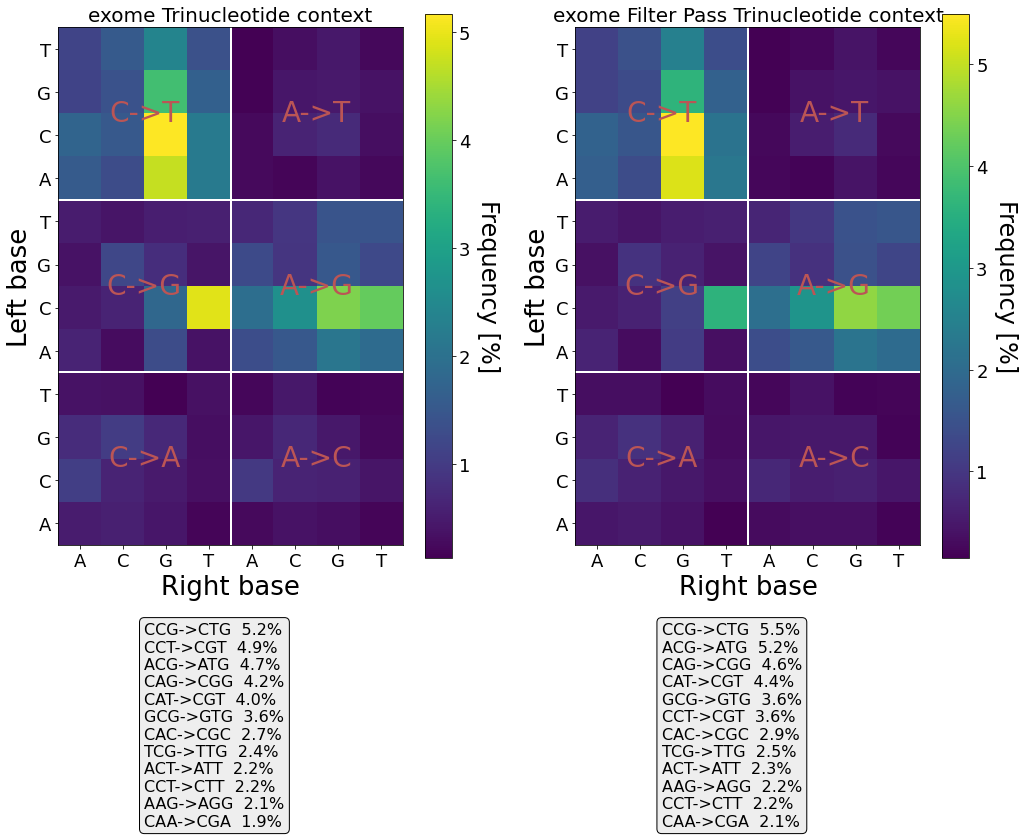

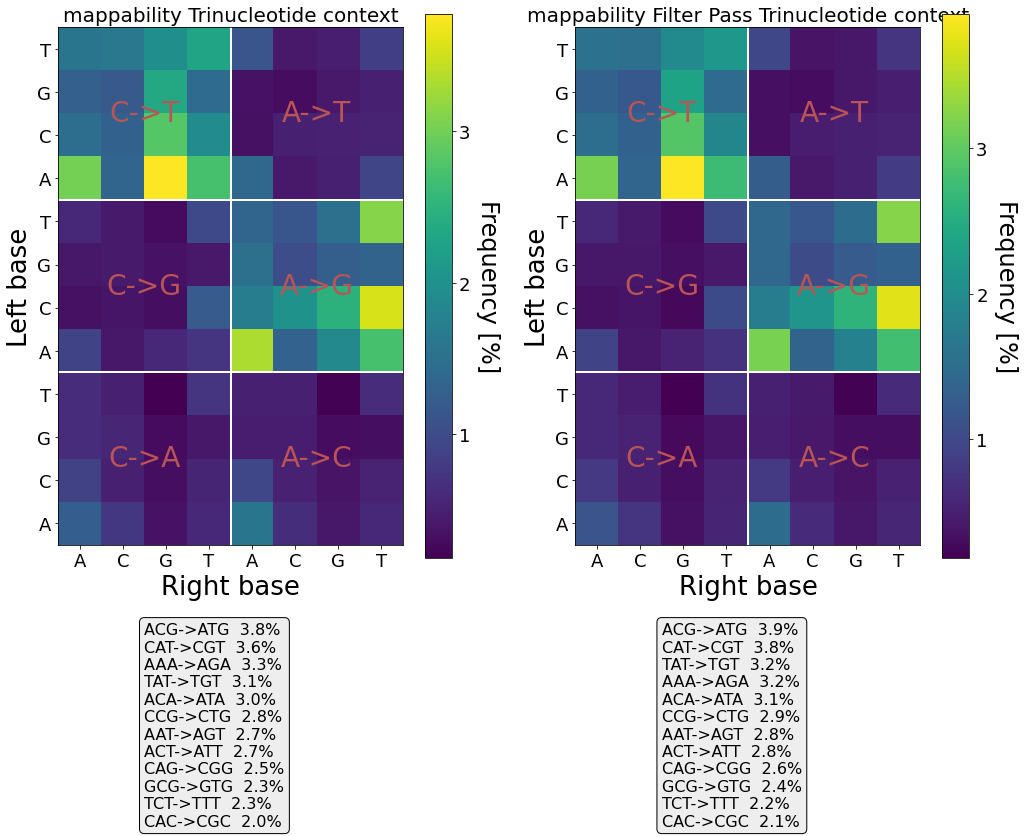

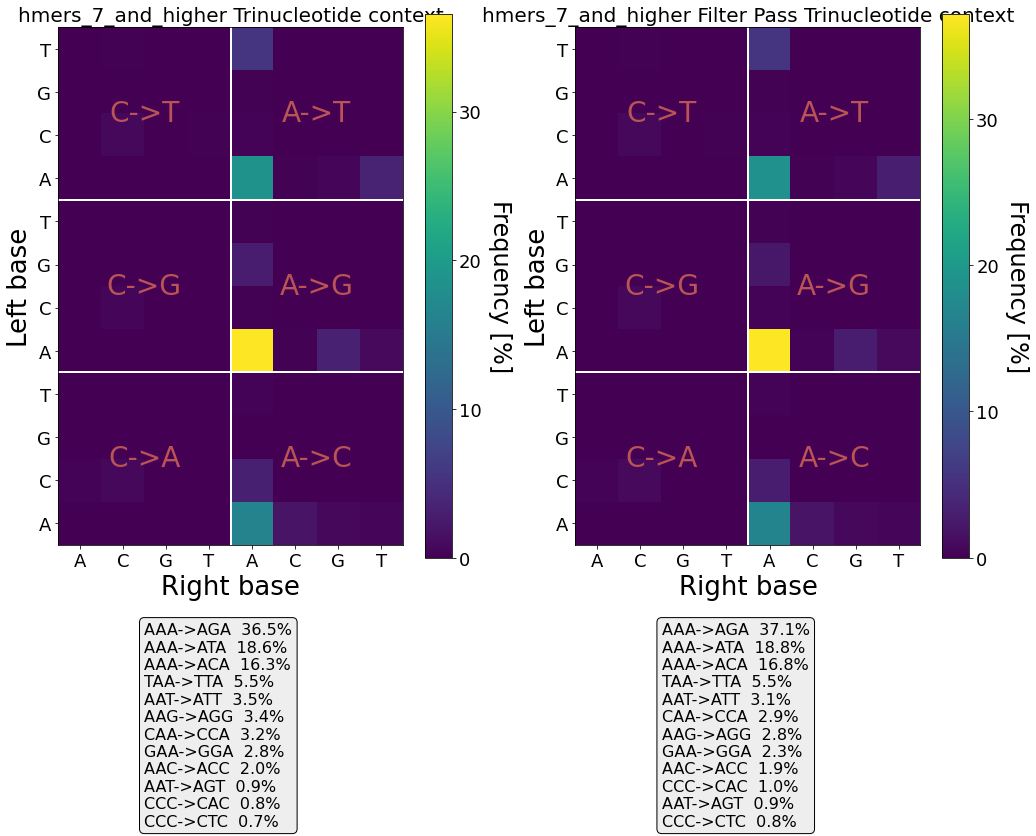

In [41]:
heatmap_annot(no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names)

# INDEL statistics

## Distribution of indel lengths

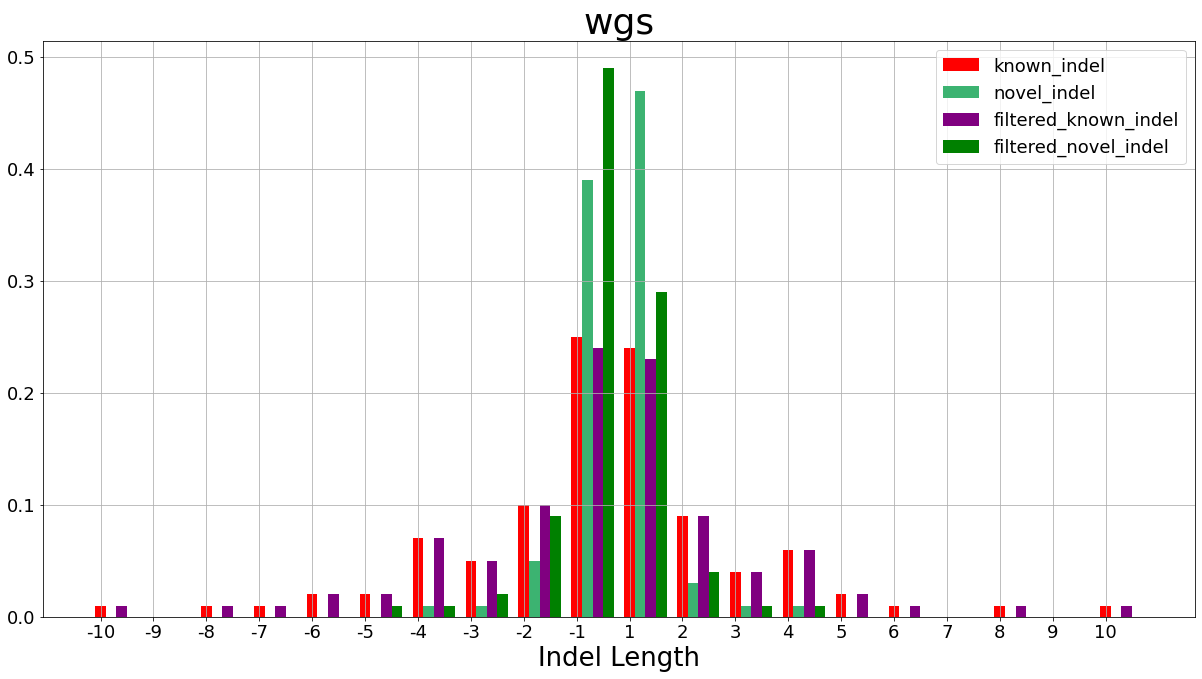

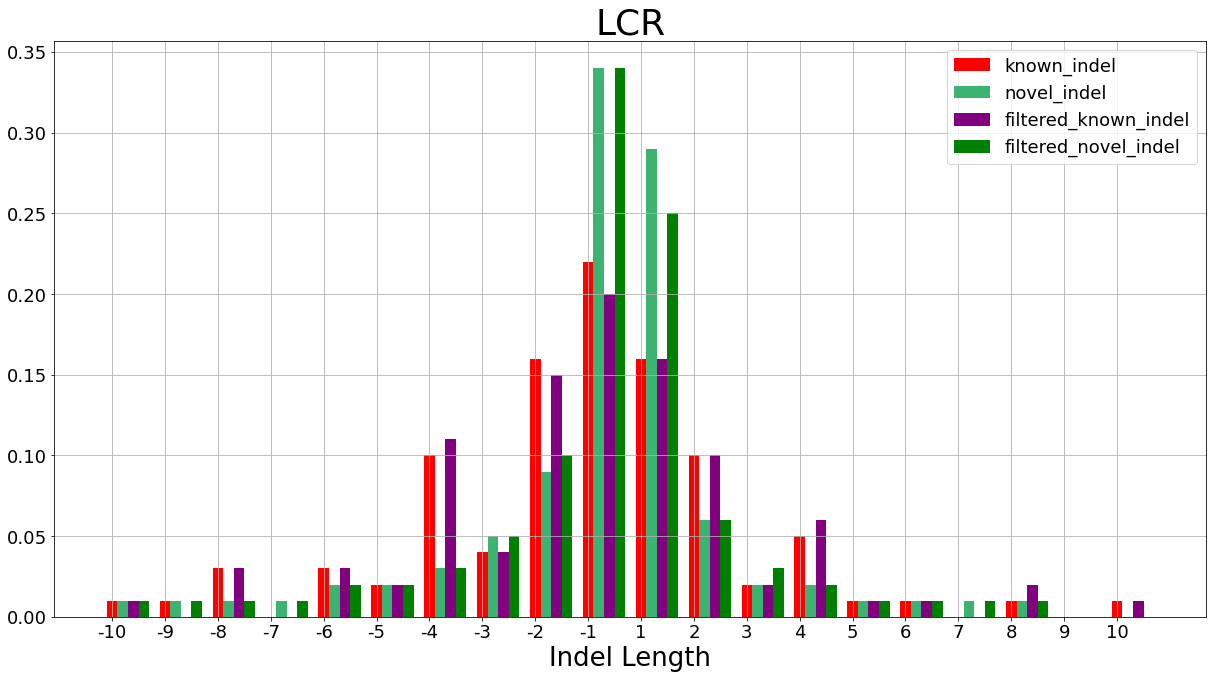

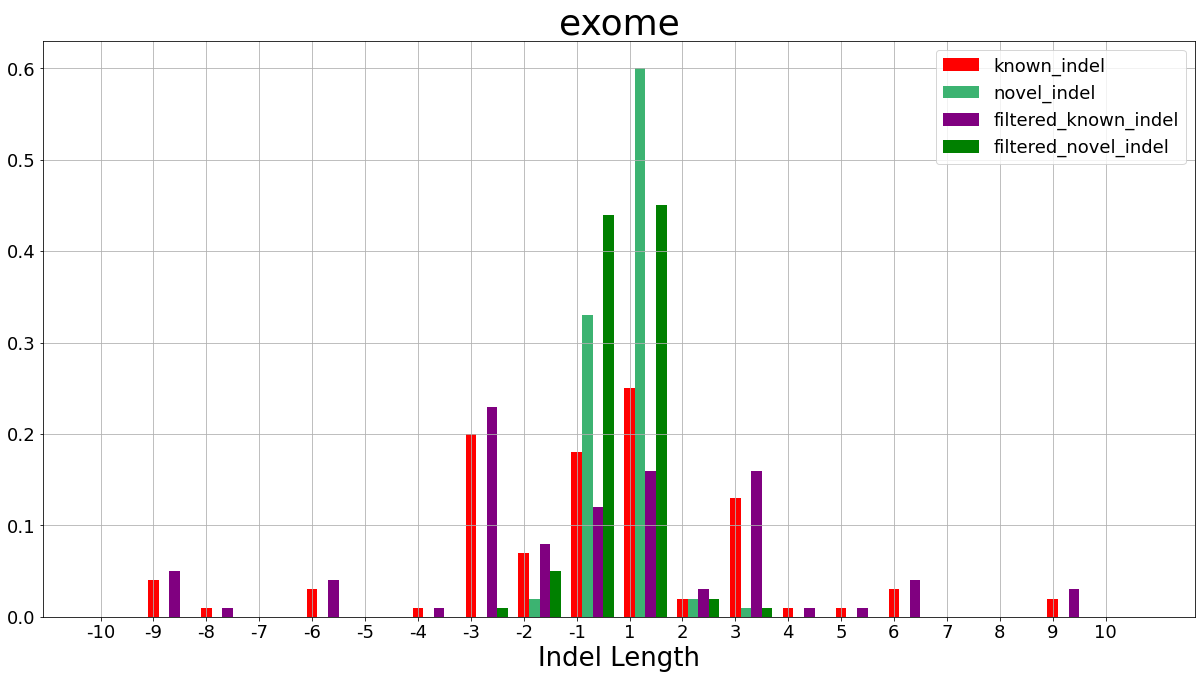

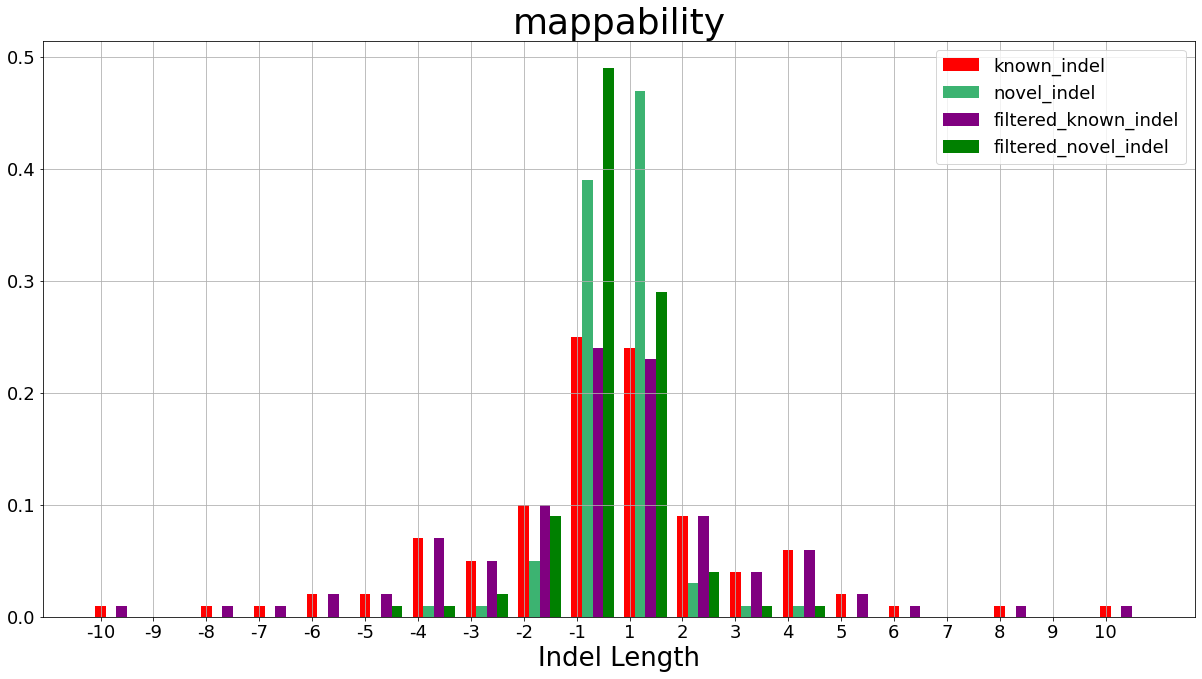

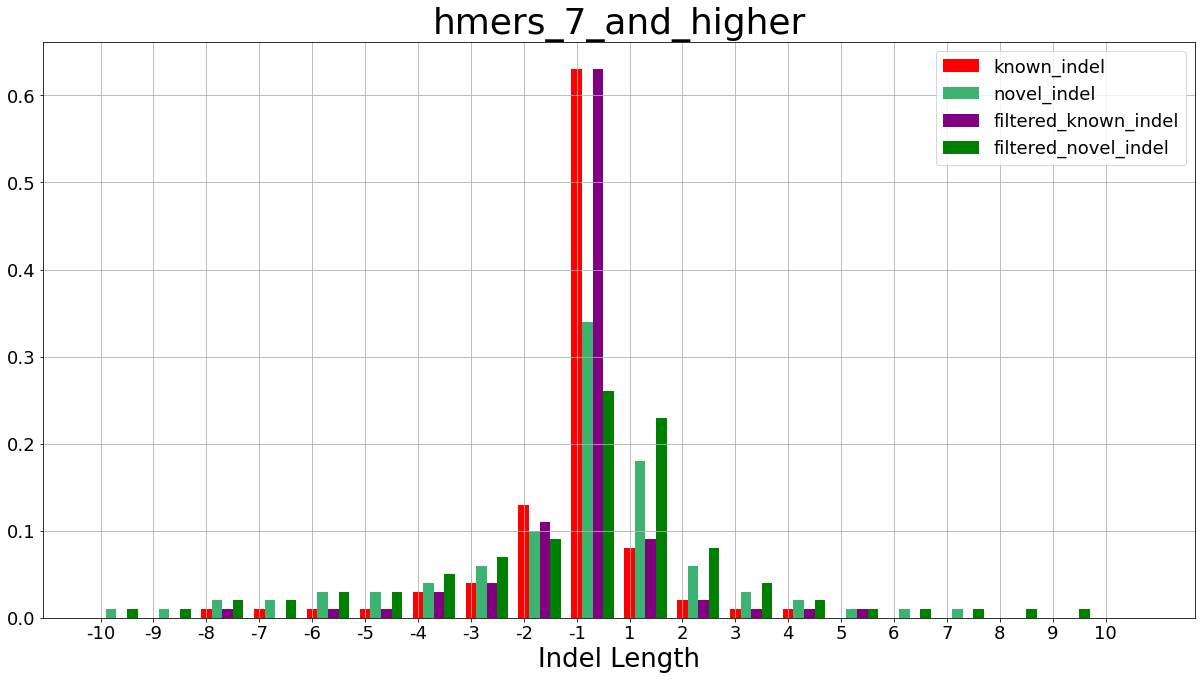

In [42]:
def ins_del_hete_graph_annot(known_indel,novel_indel,filtered_known_indel,filtered_novel_indel, title=None):
    X = np.arange(20)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    ax.bar(X + 0.00, known_indel, color = 'r', width = 0.20)
    ax.bar(X + 0.20, novel_indel, color = 'mediumseagreen', width = 0.20)
    ax.bar(X + 0.40, filtered_known_indel, color = 'purple', width = 0.20)
    ax.bar(X + 0.60, filtered_novel_indel, color = 'g', width = 0.20)

    ax.set_title(title)
    ax.set_xticks(np.arange(0,20))
    ax.set_xticklabels([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10])
    ax.legend(labels=['known_indel', 'novel_indel', 'filtered_known_indel', 'filtered_novel_indel'])
    ax.set_xlabel('Indel Length')
    
    

def ins_del_hete_graph(no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names):
    
    for no_gt_statistics_unfiltered,no_gt_statistics_filtered,annotation_name in zip(no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names):
        
        IndelLengthHistogram = pd.read_hdf(no_gt_statistics_unfiltered,'eval_IndelLengthHistogram')
        filtered_IndelLengthHistogram = pd.read_hdf(no_gt_statistics_filtered,'eval_IndelLengthHistogram')

        known_indel = IndelLengthHistogram[IndelLengthHistogram['Novelty']=='known']['Freq'].astype(float)
        novel_indel = IndelLengthHistogram[IndelLengthHistogram['Novelty']=='novel']['Freq'].astype(float)

        filtered_known_indel = filtered_IndelLengthHistogram[filtered_IndelLengthHistogram['Novelty']=='known']['Freq'].astype(float)
        filtered_novel_indel = filtered_IndelLengthHistogram[filtered_IndelLengthHistogram['Novelty']=='novel']['Freq'].astype(float)

        ins_del_hete_graph_annot(known_indel,
                   novel_indel,
                   filtered_known_indel,
                   filtered_novel_indel,
                   title=annotation_name)
        
ins_del_hete_graph(no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names)

## Insertion Deletion Statistics for h-mer indels
Number of 1-base insretion deletions in hmer of each length

In [43]:
if not is_somatic:
    display(Markdown("""## Heterozygous
    """))

In [44]:
def ins_del_hete_graph(ins_del, ax, title):
    X = np.arange(12)
    
    ax.bar(X + 0.00, ins_del.iloc[0], color = 'r', width = 0.3)
    ax.bar(X + 0.3, ins_del.iloc[1], color = 'mediumseagreen', width = 0.3)
    ax.bar(X + 0.00, -ins_del.iloc[2], color = 'purple', width = 0.3)
    ax.bar(X + 0.3, -ins_del.iloc[3], color = 'g', width = 0.3)

    ax.set_title(title, fontsize=18)
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(pd.Series(np.arange(1,13)).apply(lambda x: f"hmer {x}"),rotation=45)
    ax.legend(labels=['ins A', 'ins G', 'del A', 'del G'])
    ax.set_yticks(ax.get_yticks())
    
    ax.set_yticklabels([abs(x).astype(int) for x in ax.get_yticks()])
    ax.set_ylabel("Deletion        /       Insertion",

               loc="center")

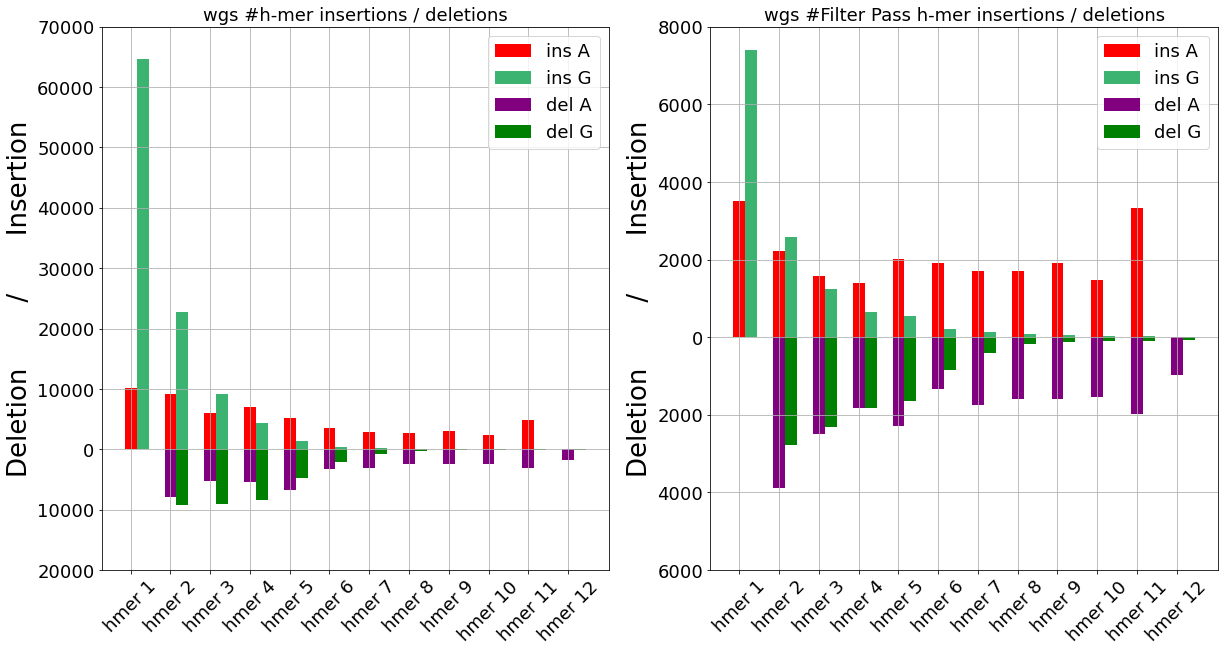

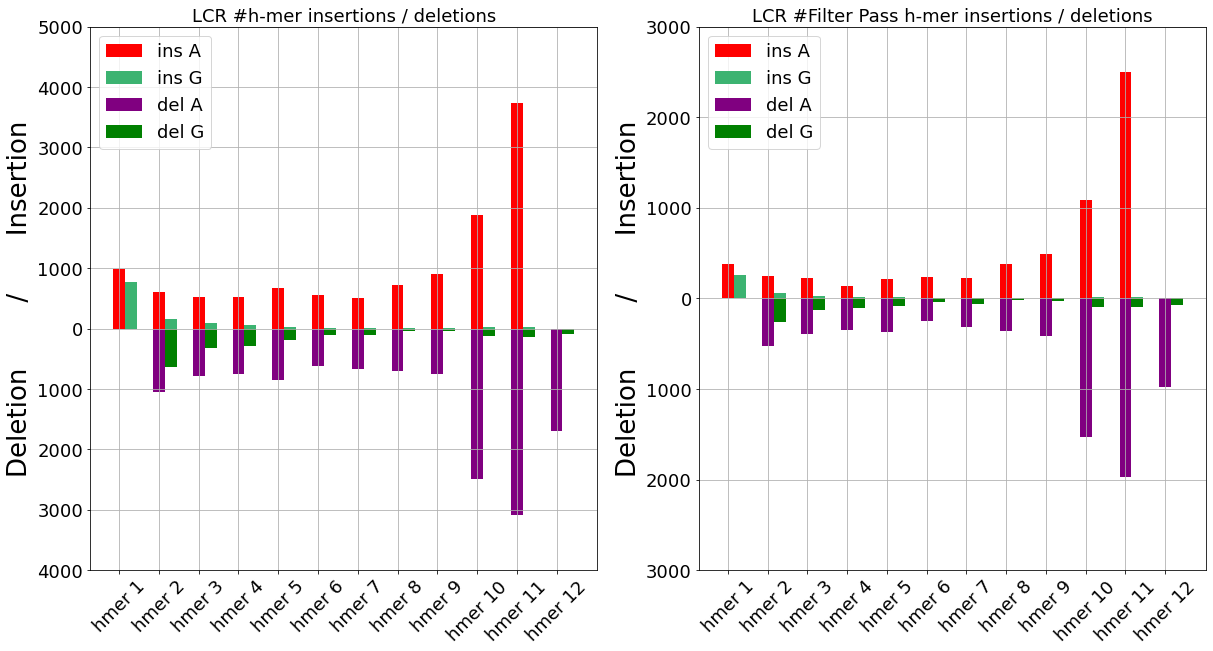

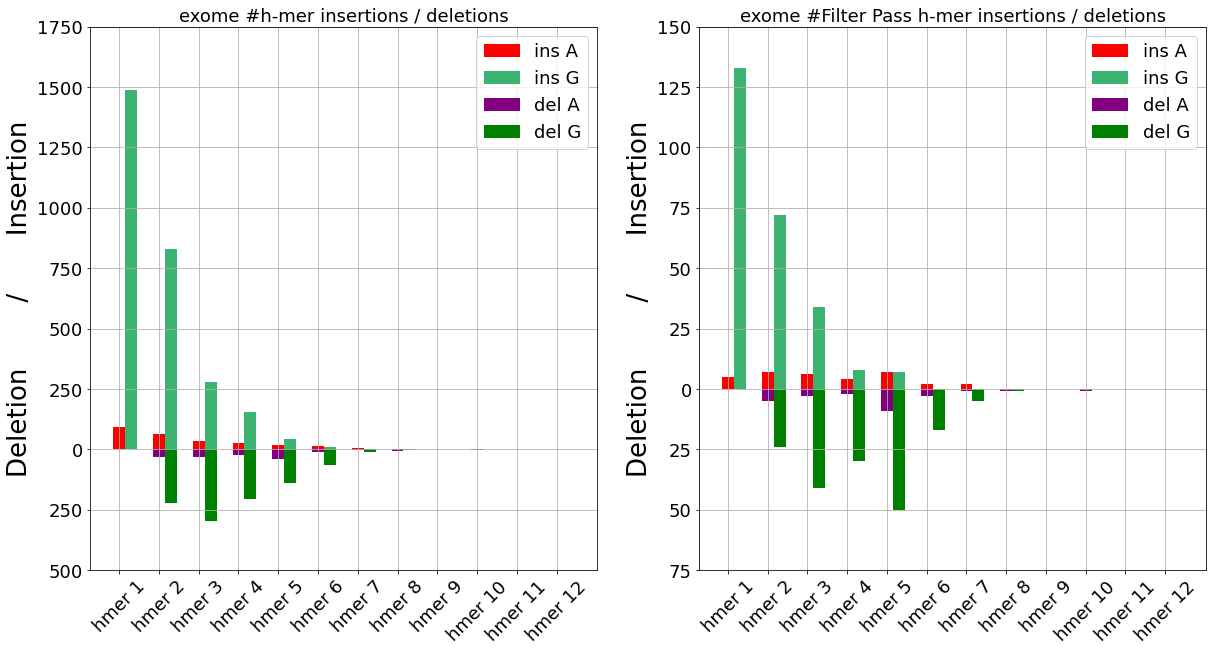

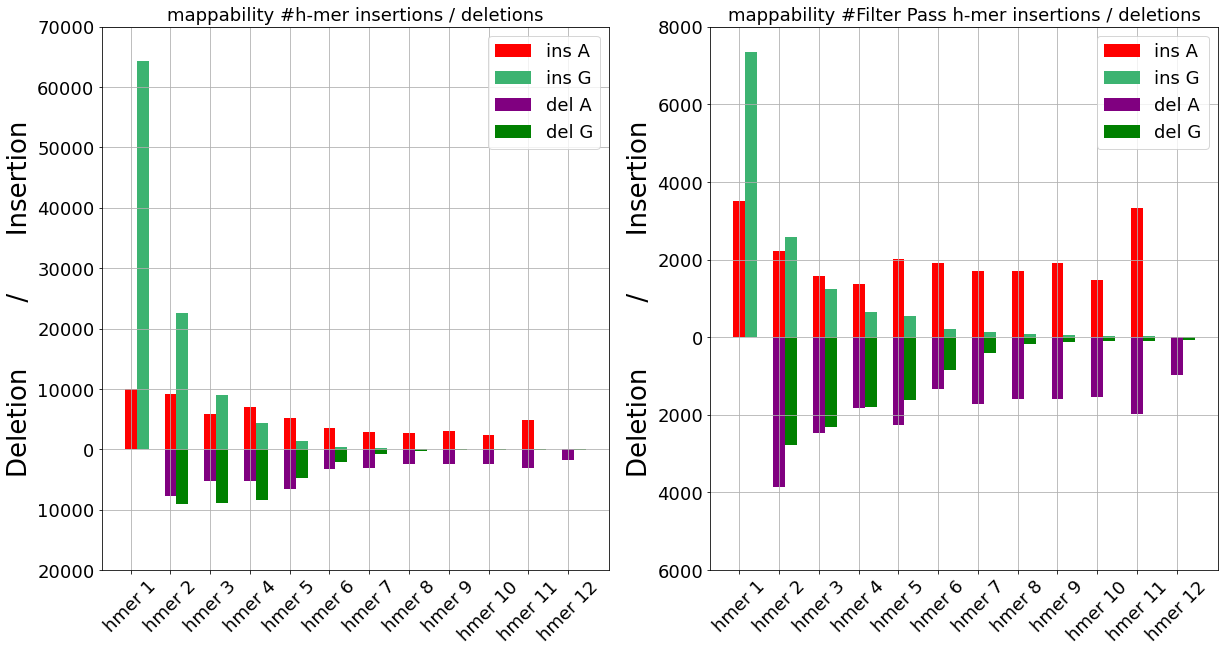

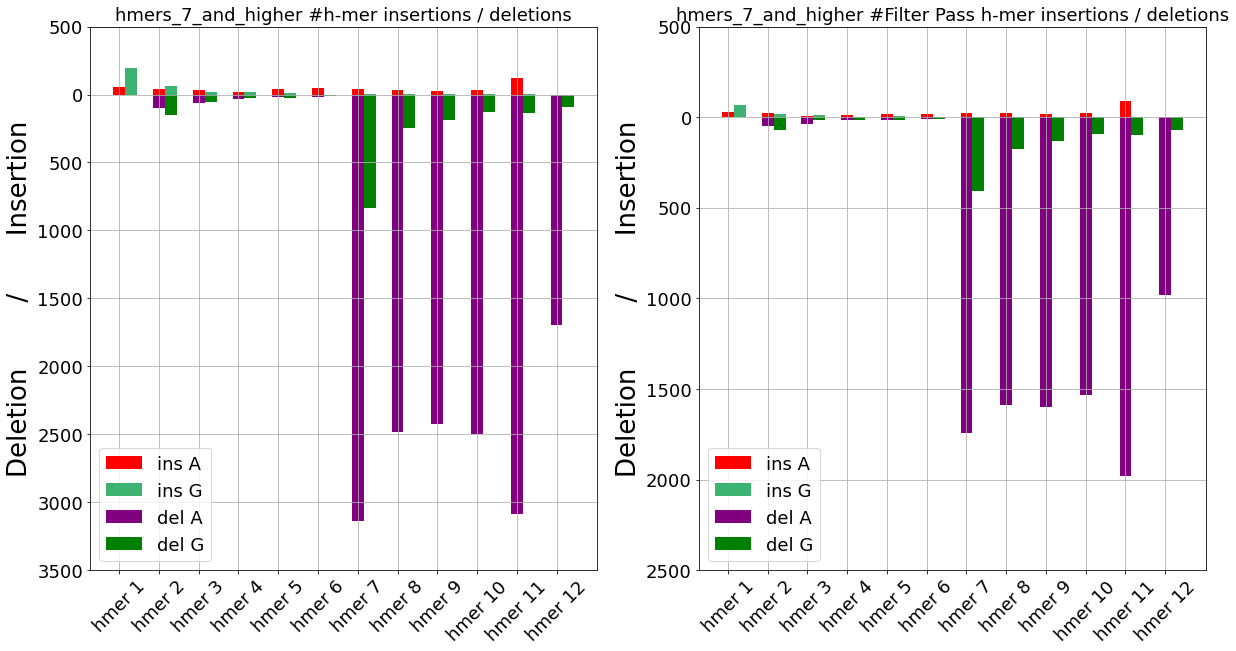

In [45]:
for no_gt_statistics_unfiltered,no_gt_statistics_filtered,annotation_name in zip(no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names):
    ins_del_hete = pd.read_hdf(no_gt_statistics_unfiltered,'ins_del_hete')
    ins_del_hete.columns = pd.Series(ins_del_hete.columns).apply(lambda x: f"h-mer {x}")
    filtered_ins_del_hete = pd.read_hdf(no_gt_statistics_filtered,'ins_del_hete')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
        
    ins_del_hete_graph(ins_del_hete, axes[0], f'{annotation_name} #h-mer insertions / deletions')
    ins_del_hete_graph(filtered_ins_del_hete, axes[1], f'{annotation_name} #Filter Pass h-mer insertions / deletions')

In [46]:
if not is_somatic:
    display(Markdown("""## Homozygous
    """))

In [47]:
if not is_somatic:
    for no_gt_statistics_unfiltered,no_gt_statistics_filtered,annotation_name in zip(no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names):
        ins_del_homo = pd.read_hdf(no_gt_statistics_unfiltered,'ins_del_homo')
        ins_del_homo.columns = pd.Series(ins_del_homo.columns).apply(lambda x: f"h-mer {x}")
        filtered_ins_del_homo = pd.read_hdf(no_gt_statistics_filtered,'ins_del_homo')
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
        
        ins_del_hete_graph(ins_del_homo, axes[0], f'{annotation_name} # insertions / deletions')
        ins_del_hete_graph(filtered_ins_del_homo, axes[1], f'{annotation_name} #Filter Pass insertions / deletions')